In [6]:
import numpy as np
from numpy.random import randn, permutation, seed
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from itertools import count, product

import sys
sys.path.append("../src/")
import pp5


from functools import partial
from pp5.distributions.kde import kde_2d, torus_gaussian_kernel_2d
from pp5.plot import contour_ramachandran

In [7]:
dataset = pd.read_csv('dataset.csv')

In [8]:
from pp5.codons import AA_CODONS, ACIDS_1TO3
CODONS = {}
for c in AA_CODONS:
    a = c[0]
    if a not in CODONS:
        CODONS[a] = []
    CODONS[a].append(c)
    
CODONS = {
    a: c for a, c in CODONS.items() if len(c) > 1
}

RANGES = {
    'SHEET': [-200,-20,60,200],
    'HELIX': [-120,20,-100,20],
}

In [9]:
font_size = 13
plt.rc('font', family='normal')
plt.rc('axes', titlesize=font_size*1.25, titleweight='bold')    # fontsize of the x and y labels
plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size, loc='lower right')    # legend fontsize

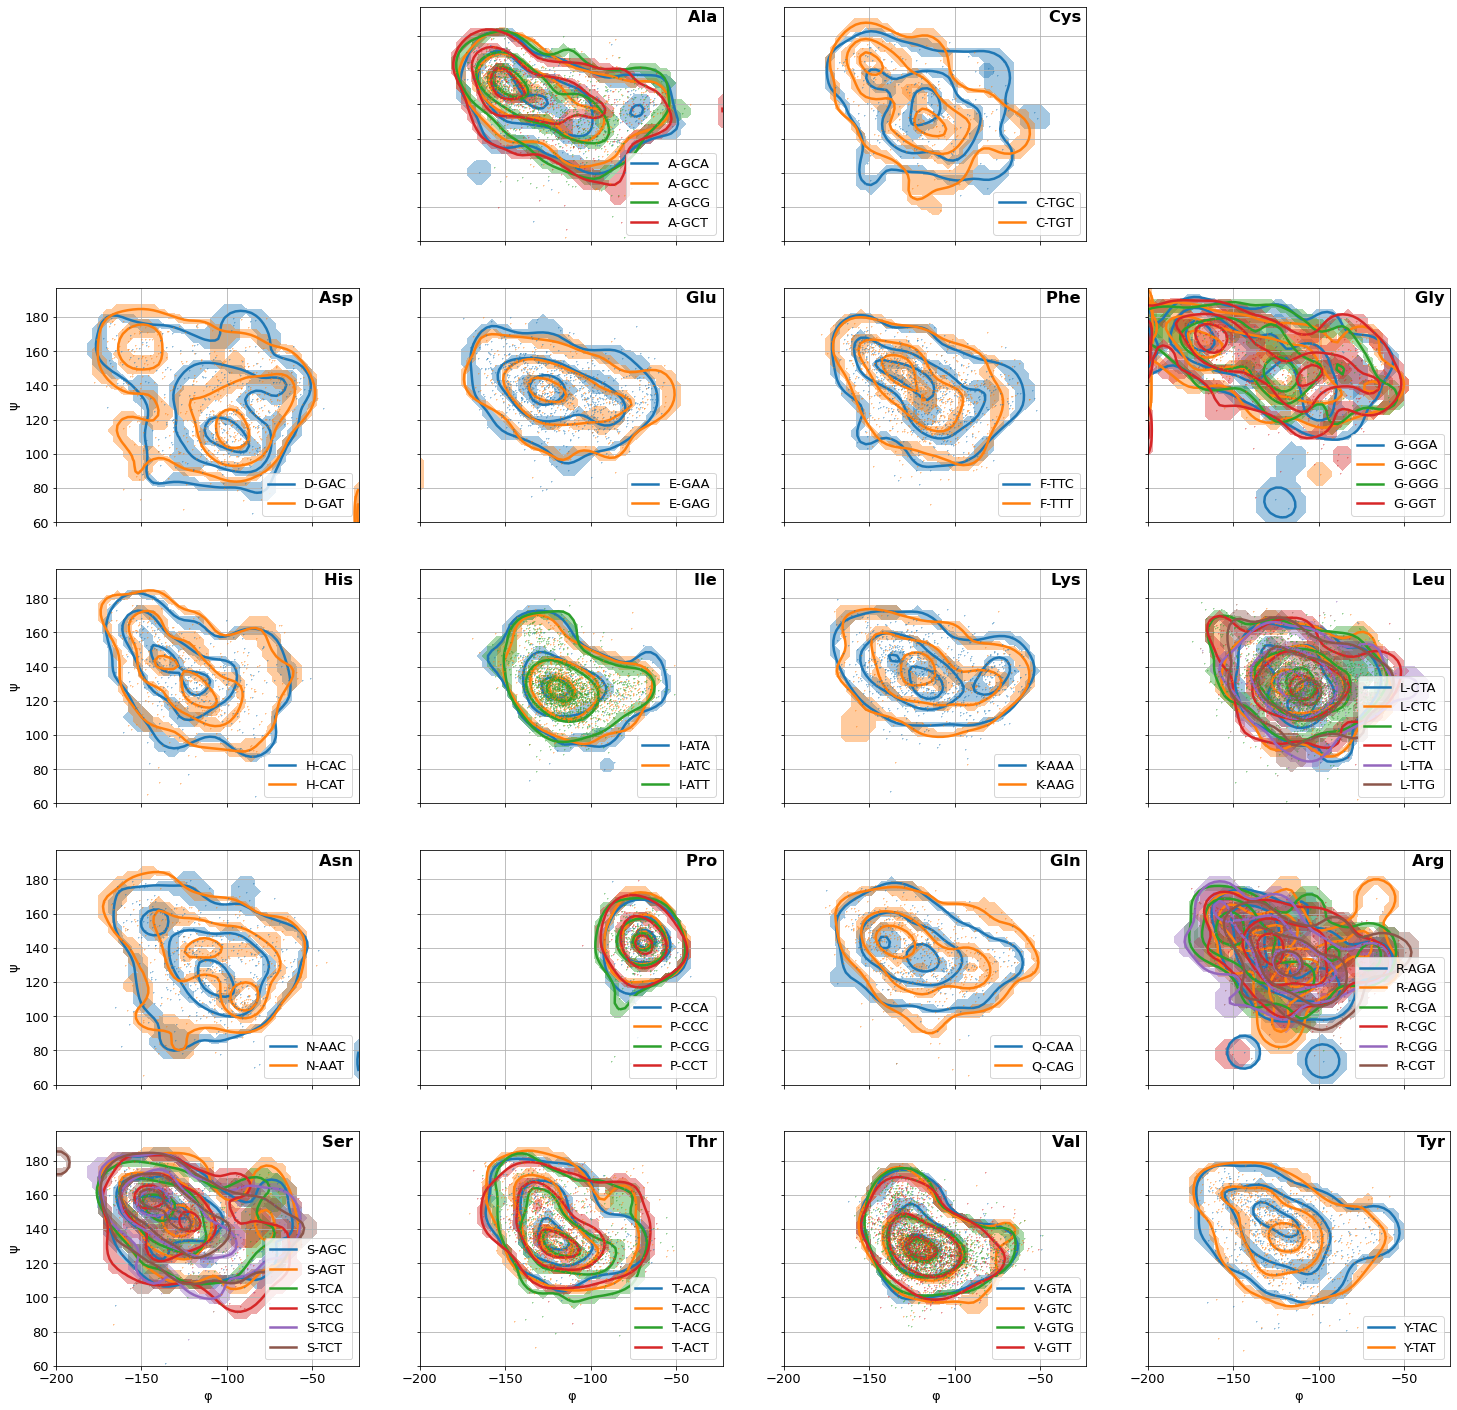

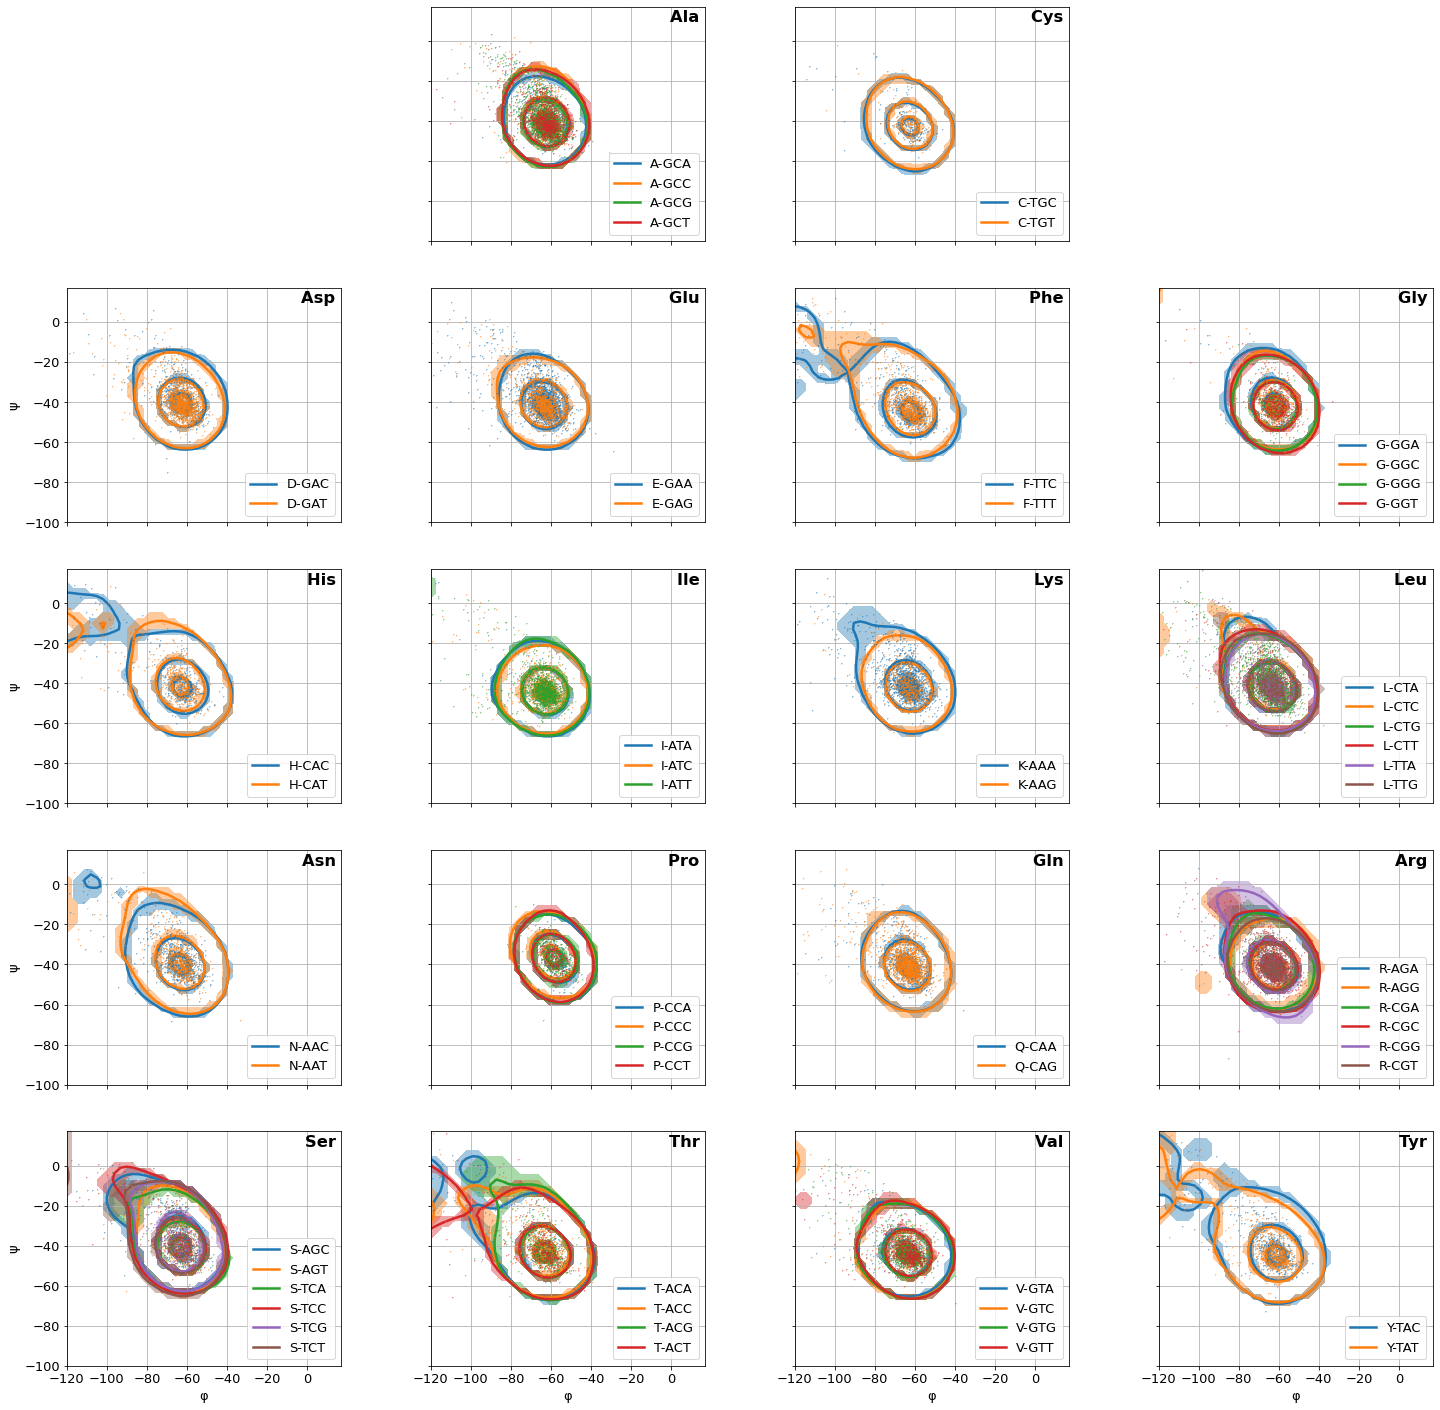

In [21]:
for ss in RANGES.keys():
    with PdfPages(f"ramachandran-codon_{ss}.pdf") as export_pdf:
        fig = plt.figure(figsize=(25,25))
        axs = fig.subplots(5, 4, sharex='all', sharey='all')
        axs_shape = axs.shape
        axs_idx = [*product(*[range(s) for s in axs.shape])]
        axs_idx_remove = [
            (i,j) for i,j in axs_idx if i==0 and j in [0, 3]
        ]
        for idx in axs_idx_remove:
            axs[idx].set_visible(False)
        axs_idx_include = [
            idx for idx in axs_idx if idx not in axs_idx_remove
        ]
        for (aa, codons), idx, n in zip(CODONS.items(), axs_idx_include, count()):
            angles = {
                c: dataset.query(f'codon=="{c}" and condition_group==@ss and psi>={RANGES[ss][2]} and psi<={RANGES[ss][3]}')[['phi', 'psi']].to_numpy()*np.pi/180
                for c in codons
            }
            ax = axs[idx]
            contour_ramachandran(
                angles=angles,
                ranges=np.array(RANGES[ss])*np.pi/180,
                num_bootstraps=200,
                sigma=10.*np.pi/180,
                ax=ax,
            )
            i, j = idx
            if j > 0:
                ax.set_ylabel(None)
            if i < axs_shape[0]-1:
                ax.set_xlabel(None)
            ax.set_title(f"{ACIDS_1TO3[aa]} ", y=1.0, pad=-15, loc='right')

        export_pdf.savefig(bbox_inches='tight') 
        plt.show()